## Лабораторная работа №8
### Выполнила Прудникова А. А.  М8О-408Б-20
#### Вариант 4

Используя схемы переменных направлений и дробных шагов, решить двумерную начально-краевую задачу для дифференциального уравнения параболического типа. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $u(x, y, t)$. Исследовать зависимость погрешности от сеточных параметров $\tau$ и $h_x$, $h_y$.

In [3]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import warnings
import random
import glob
import moviepy.editor as mpy

from ipywidgets import interact
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
from tqdm import tqdm

from functools import reduce
from mpl_toolkits.mplot3d import Axes3D

$$\displaystyle\frac{\partial u}{\partial t} =  a\displaystyle\frac{\partial^2 u}{\partial x^2} + a\displaystyle\frac{\partial^2 u}{\partial y^2}, \; a >  0$$


\begin{equation*}
 \begin{cases}
   u (0, y, \: t) = \cosh{y} \cdot e^{-3at}
   \\
   u (\frac{\pi}{4}, y, \: t) = 0
   \\
   u (x, 0, \: t) = \cos{2x} \cdot e^{-3at}
   \\
   u_{y}' (x, \ln{2}, \: t) =  \frac{3}{4} \cos{2x} \cdot e^{-3at}
   \\
   u(x, y, 0) =  cos{2x} \cosh{y}
 \end{cases}
\end{equation*}

$$u(x, y, t) =  \cos{2x} \cosh{y} e^{-3at} $$

In [4]:
def psi_0(x, t, a = 1):
    return math.cos(2*x) * math.exp(-3*a*t)

def psi_1(x, t, a = 1):
    return 3*math.cos(2*x)*math.exp(-3*a*t) / 4

def phi_0(y, t, a = 1):
    return math.cosh(y) * math.exp(-3*a*t)

def phi_1(y, t, a = 1):
    return 0

def u0(x, y, a = 1):
    return math.cos(2*x) * math.cosh(y)

def u(x, y, t, a = 1):
    return math.cos(2*x) * math.cosh(y) * math.exp(-3*a*t)

In [5]:
class Schema:
    def __init__(self, a = 1, rho = u0, psi0 = psi_0, psi1 = psi_1, phi0 = phi_0, phi1 = phi_1,
                 lx0 = 0, lx1 = math.pi/4, ly0 = 0, ly1 = math.log(2), T = 5, order2nd = True):
        self.psi0 = psi0
        self.psi1 = psi1
        self.phi0 = phi0
        self.phi1 = phi1
        self.rho0 = rho
        self.T = T
        self.lx0 = lx0
        self.lx1 = lx1
        self.ly0 = ly0
        self.ly1 = ly1
        self.tau = None
        self.hx = None
        self.hy = None
        self.order = order2nd
        self.a = a
        self.Nx = None
        self.Ny = None
        self.K = None
        self.cx = None
        self.bx = None
        self.cy = None
        self.by = None
        self.hx2 = None
        self.hy2 = None
        
        
    def set_l0_l1(self, lx0, lx1, ly0, ly1):
        self.lx0 = lx0
        self.lx1 = lx1
        self.ly0 = ly0
        self.ly1 = ly1
        
    def set_T(self, T):
        self.T = T
        
    def compute_h(self):
        self.hx = (self.lx1 - self.lx0) / (self.Nx - 1)
        self.hy = (self.ly1 - self.ly0) / (self.Ny - 1)
        self.hx2 = self.hx * self.hx
        self.hy2 = self.hy * self.hy
        
    def compute_tau(self):
        self.tau = self.T / (self.K - 1)
        
    @staticmethod
    def race_method(A, b):
        P = [-item[2] for item in A]
        Q = [item for item in b]
    
        P[0] /= A[0][1]
        Q[0] /= A[0][1]
    
        for i in range(1, len(b)):
            z = (A[i][1] + A[i][0] * P[i-1])
            P[i] /= z
            Q[i] -= A[i][0] * Q[i-1]
            Q[i] /= z

        for i in range(len(Q) - 2, -1, -1):
            Q[i] += P[i] * Q[i + 1]

        return Q    
      
    @staticmethod
    def nparange(start, end, step = 1):
        now = start
        e = 0.00000000001
        while now - e <= end:
            yield now
            now += step
            
    def compute_left_edge(self, X, Y, t, square):
        for i in range(self.Ny):
            square[i][0] = self.phi0(Y[i][0], t, self.a)
            
    def compute_right_edge(self, X, Y, t, square):
        for i in range(self.Ny):
            square[i][-1] = self.phi1(Y[i][-1], t, self.a)
            
    def compute_bottom_edge(self, X, Y, t, square):
        for j in range(1, self.Nx - 1):
            square[0][j] = self.psi0(X[0][j], t, self.a)
            
            
    def compute_line_first_step(self, i, X, Y, last_square, now_square):
        hy2 = self.hy2
        hx2 = self.hx2
        
        b = self.bx
        c = self.cx
        
        A = [(0, b, c)]
        w = [
            -self.cy*self.order*last_square[i-1][1] -
            ((self.order + 1)*hx2*hy2 - 2*self.cy*self.order)*last_square[i][1] -
            self.cy*self.order*last_square[i+1][1] - c*now_square[i][0]
        ]
        A.extend([(c, b, c) for _ in range(2, self.Nx - 2)])
        w.extend([
            -self.cy*self.order*last_square[i-1][j] -
            ((self.order + 1)*hx2*hy2 - 2*self.cy*self.order)*last_square[i][j] -
            self.cy*self.order*last_square[i+1][j]
            for j in range(2, self.Nx - 2)
        ])
        
        A.append((c, b, 0))
        w.append(
            -self.cy*self.order*last_square[i-1][-2] -
            ((self.order + 1)*hx2*hy2 - 2*self.cy*self.order)*last_square[i][-2] -
            self.cy*self.order*last_square[i+1][-2] - c*now_square[i][-1]
        )
        
        line = self.race_method(A, w)
        
        for j in range(1, self.Nx - 1):
            now_square[i][j] = line[j - 1]
            
                
    def compute_line_second_step(self, j, X, Y, t, last_square, now_square):
        hx2 = self.hx2
        hy2 = self.hy2
        
        c = self.cy
        b = self.by
        
        A = [(0, b, c)]
        w = [
            -self.cx*self.order*last_square[1][j - 1] -
            ((self.order + 1)*hx2*hy2 - 2*self.cx*self.order)*last_square[1][j] -
            self.cx*self.order*last_square[1][j + 1] - c*now_square[0][j]
        ]
        
        A.extend([(c, b, c) for _ in range(2, self.Ny - 1)])
        w.extend([
            -self.cx*self.order*last_square[i][j - 1] -
            ((self.order + 1)*hx2*hy2 - 2*self.cx*self.order)*last_square[i][j] -
            self.cx*self.order*last_square[i][j + 1]
            for i in range(2, self.Ny - 1)
        ])
        
        koeffs = self.implict_top_approx(j, X, Y, t, now_square, last_square)
        A.append(koeffs[:-1])
        w.append(koeffs[-1])
        
        line = self.race_method(A, w)
        
        for i in range(1, self.Ny):
            now_square[i][j] = line[i - 1]
            
            
    def explict_top_approx(self, X, Y, t, square):
        for j in range(1, self.Nx - 1):
            square[-1][j] = 2*self.hy*self.psi1(X[-1][j], t, self.a)
            square[-1][j] += 4*square[-2][j] - square[-3][j]
            square[-1][j] /= 3
        
    def implict_top_approx(self, j, X, Y, t, square, last_square):
        hx2 = self.hx2
        hy2 = self.hy2
        
        c = 2 * self.a * self.tau * hx2
        b = -(c + (1 + self.order)*hx2*hy2)
        
        w = -self.cx*self.order*last_square[-1][j - 1]
        w -= ((self.order + 1)*hx2*hy2 - 2*self.cx*self.order)*last_square[-1][j]
        w -= self.cx*self.order*last_square[-1][j + 1]
        w -= c*self.hy*self.psi1(X[-1][j], t, self.a)
        
        return (c, b, 0, w)
    
    
    def explict_top_approx_0(self, X, Y, t, square):
        for j in range(1, self.Nx - 1):
            square[-1][j] = self.hy*self.psi1(X[-1][j], t, self.a)
            square[-1][j] += square[-2][j]
    
    def implict_top_approx_0(self, j, X, Y, t, square, last_square):
        return (-1, 1, 0, self.hy*self.psi1(X[-1][j], t, self.a))
        
    def compute_square(self, X, Y, t, last_square):
        square = [[0.0 for _ in range(self.Nx)] for _ in range(self.Ny)]
        self.compute_left_edge(X, Y, t - 0.5*self.tau, square) 
        self.compute_right_edge(X, Y, t - 0.5*self.tau, square)
        self.compute_bottom_edge(X, Y, t - 0.5*self.tau, square)
         
        for i in range(1, self.Ny - 1):
            self.compute_line_first_step(i, X, Y, last_square, square)
        self.explict_top_approx(X, Y, t - 0.5*self.tau, square)
        
        last_square = square
        square = [[0.0 for _ in range(self.Nx)] for _ in range(self.Ny)]
        self.compute_left_edge(X, Y, t, square)
        self.compute_right_edge(X, Y, t, square)
        self.compute_bottom_edge(X, Y, t, square)
        
        for j in range(1, self.Nx - 1):
            self.compute_line_second_step(j, X, Y, t, last_square, square)
        
        return square
        
    
    def init_t0(self, X, Y):
        first = [[0.0 for _ in range(self.Nx)] for _ in range(self.Ny)]
        for i in range(self.Ny):
            for j in range(self.Nx):
                first[i][j] = self.rho0(X[i][j], Y[i][j], self.a)
        return first
        
        
    
    def __call__(self, Nx=20, Ny=20, K=20):
        self.Nx, self.Ny, self.K = Nx, Ny, K 
        self.compute_tau()
        self.compute_h()
        
        self.bx = -2*self.a*self.tau*self.hy2
        self.bx -= (1 + self.order)*self.hx2*self.hy2
        self.cx = self.a * self.tau * self.hy2
        
        self.cy = self.a * self.tau * self.hx2
        self.by = -2*self.a*self.tau*self.hx2
        self.by -= (1 + self.order)*self.hx2*self.hy2
        
        x = list(self.nparange(self.lx0, self.lx1, self.hx))
        y = list(self.nparange(self.ly0, self.ly1, self.hy))
        X = [x for _ in range(self.Ny)]
        Y = [[y[i] for _ in x] for i in range(self.Ny)]
        
        taus = [0.0]
        
        ans = [self.init_t0(X, Y)]
        
        for t in self.nparange(self.tau, self.T, self.tau):
            ans.append(self.compute_square(X, Y, t, ans[-1]))
            taus.append(t)

        return X, Y, taus, ans

Реальное значение функции на плоскости в определённый момент времени:

In [6]:
def real_z_by_time(lx0, lx1, ly0, ly1, t, f):
    x = np.arange(lx0, lx1 + 0.002, 0.002)
    y = np.arange(ly0, ly1 + 0.002, 0.002)
    X = np.ones((y.shape[0], x.shape[0]))
    Y = np.ones((x.shape[0], y.shape[0]))
    Z = np.ones((y.shape[0], x.shape[0]))
    for i in range(Y.shape[0]):
        Y[i] = y
    Y = Y.T
    for i in range(X.shape[0]):
        X[i] = x
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = f(X[i, j], Y[i, j], t)
    return X, Y, Z

Значение погрешности в определённый момент времени.

In [7]:
def epsilon(X, Y, t, z, ut = u, a = 1):
    ans = 0.0
    for i in range(len(z)):
        for j in  range(len(z[i])):
            ans += (ut(X[i][j], Y[i][j], t, a) - z[i][j])**2
    return (ans / len(z) / len(z[0]))**0.5

#### Визуализация

In [8]:
def step_slice(lst, step):
    return lst[step]


def animate_list(lst, play=False, interval=200):
    slider = widgets.IntSlider(min=0, max=len(lst) - 1, step=1, value=0)
    if play:
        play_widjet = widgets.Play(interval=interval)
        widgets.jslink((play_widjet, 'value'), (slider, 'value'))
        display(play_widjet)
    return interact(step_slice,
                    lst=fixed(lst),
                    step=slider)

In [9]:
def plot_by_time(X, Y, T, Z, j, a, extrems, plot_true = True):
    t = T[j]
    z = Z[j]
    fig = plt.figure(num=1, figsize=(20, 13), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_surface(np.array(X), np.array(Y), np.array(z))
    if plot_true:
        ax.plot_wireframe(*real_z_by_time(0, math.pi/4, 0, math.log(2), t, u), color="green")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z') 
    ax.set_title(
        't = ' + str(round(t, 8)) + " RMSE = " + str(round(epsilon(X, Y, t, z, a = a), 11)), 
        loc = "right", fontsize=25
    )
    ax.set_zlim(extrems[0], extrems[1])
    fig.tight_layout()
    plt.close(fig)
    return fig

def search_minmax(zz):
    z = zz[0]
    minimum, maximum = z[0][0], z[0][0]
    for i in range(len(z)):
        for j in range(len(z[i])):
            minimum = z[i][j] if z[i][j] < minimum else minimum
            maximum = z[i][j] if z[i][j] > maximum else maximum
    return minimum, maximum

def plot_animate(nx = 15, ny = 15, k=50, t=1, a = 1, plot_true = False):
    schema = Schema(T = t, a = a, order2nd = True)
    xx, yy, tt, zz = schema(Nx = nx, Ny = ny, K = k)
    extrems = search_minmax(zz)
    plots = []
    for j in range(len(tt)):
        plots.append(plot_by_time(xx, yy, tt, zz, j, a, extrems, plot_true))
    animate_list(plots, play=True, interval=2000)

<h3><center> Зависимость погрешности расчетов от параметров </center></h3>

In [11]:
first = Schema(T = 1, order2nd = False) #метод дробных шагов
second = Schema(T = 1, order2nd = True) #метод переменных направлений

In [15]:
def get_graphic_h(solver, time = 0, tsteps = 400):
    h = []
    e = []
    for N in range(4, 35, 1):
        x, y, t, z = solver(Nx = N, Ny = N, K = tsteps)
        h.append(solver.hx)
        e.append(epsilon(x, y, t[time], z[time]))
    return h, e

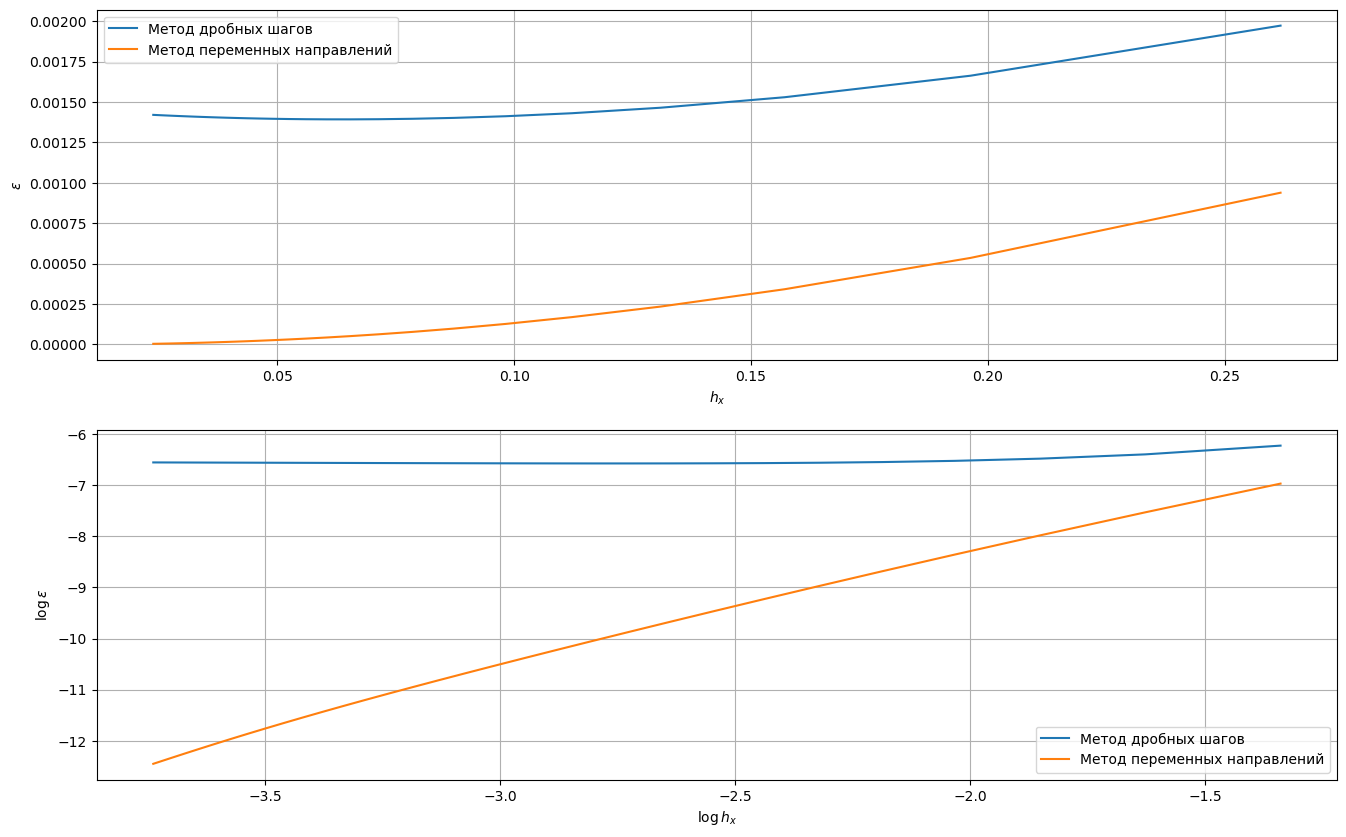

In [16]:
TSTEPS = 300
time = random.randint(0, TSTEPS - 1)

plt.figure(figsize = (16, 10))

plt.title("Зависимость погрешности от длины шага при t = " + str(time / TSTEPS))

plt.subplot(2, 1, 1)

h1, e1 = get_graphic_h(first, time, TSTEPS)
h2, e2 = get_graphic_h(second, time, TSTEPS)

plt.plot(h1, e1, label="Метод дробных шагов")
plt.plot(h2, e2, label="Метод переменных направлений")

plt.xlabel("$h_x$")
plt.ylabel("$\epsilon$")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, h1)), list(map(math.log, e1)), label="Метод дробных шагов")
plt.plot(list(map(math.log, h2)), list(map(math.log, e2)), label="Метод переменных направлений")
plt.xlabel("$\log{h_x}$")
plt.ylabel("$\log{\epsilon}$")
plt.legend()
plt.grid()

#### Построение зависимости погрешности от $\tau$

In [17]:
def get_graphic_tau(solver):
    tau = []
    e = []
    for K in range(15, 100, 2):
        x, y, t, z = solver(Nx = 10, Ny = 10, K = K)
        tau.append(solver.tau)
        time = K // 2
        e.append(epsilon(x, y, t[time], z[time]))
    return tau, e

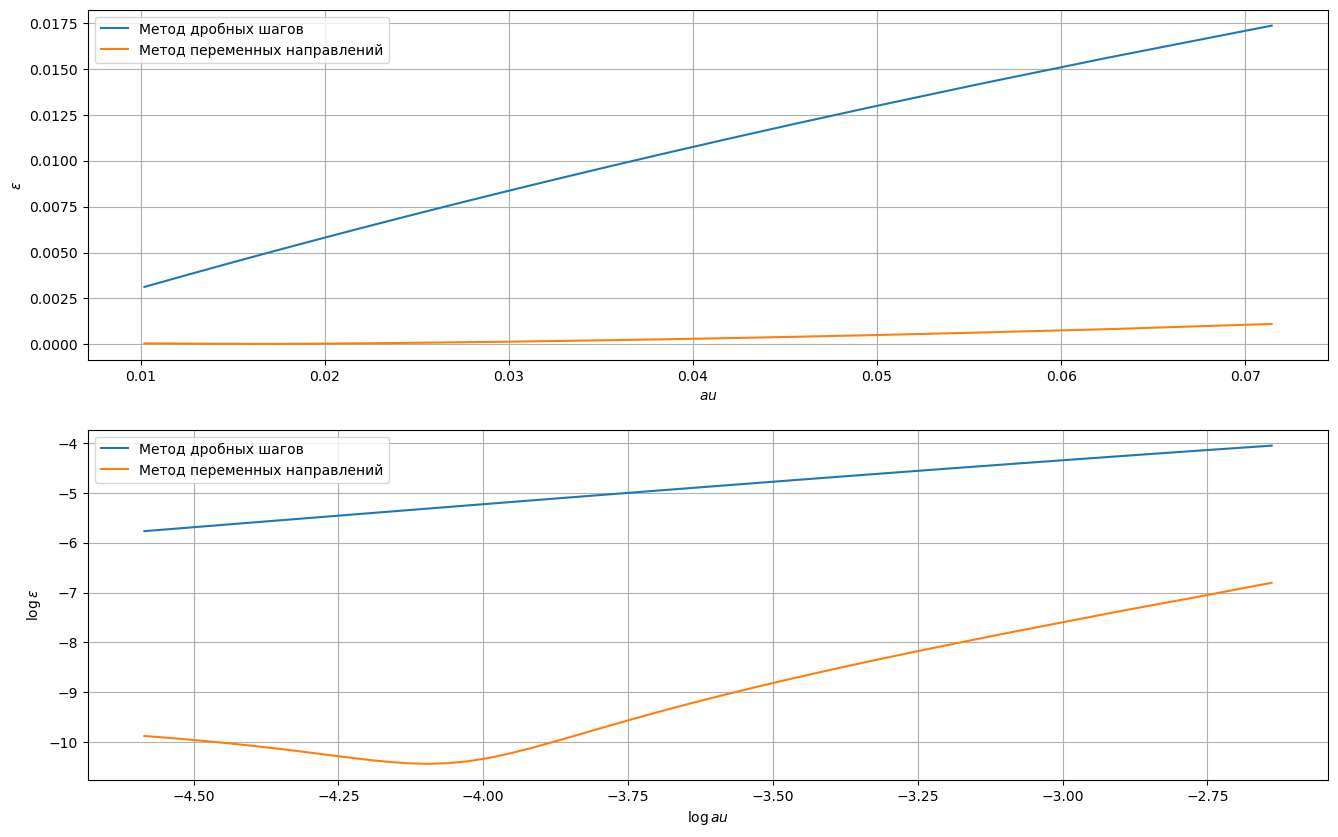

In [18]:
plt.figure(figsize = (16, 10))

plt.title("Зависимость погрешности от длины шага по времени")
plt.subplot(2, 1, 1)

tau1, e1 = get_graphic_tau(first)
tau2, e2 = get_graphic_tau(second)

plt.plot(tau1, e1, label="Метод дробных шагов")
plt.plot(tau2, e2, label="Метод переменных направлений")

plt.xlabel("$\tau$")
plt.ylabel("$\epsilon$")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, tau1)), list(map(math.log, e1)), label="Метод дробных шагов")
plt.plot(list(map(math.log, tau2)), list(map(math.log, e2)), label="Метод переменных направлений")
plt.xlabel("$\log{\tau}$")
plt.ylabel("$\log{\epsilon}$")
plt.legend()
plt.grid()

#### Общая зависимость погрешости от сеточных параметров

In [19]:
def full_epsilon(X, Y, T, Z):
    ans = 0.0
    for k in range(len(T)):
        for i in range(len(X)):
            for j in  range(len(X[i])):
                ans += (u(X[i][j], Y[i][j], T[k]) - Z[k][i][j])**2
    return (ans / len(T) / len(X) / len(X[0]))**0.5

100%|██████████| 30/30 [03:38<00:00,  7.29s/it]


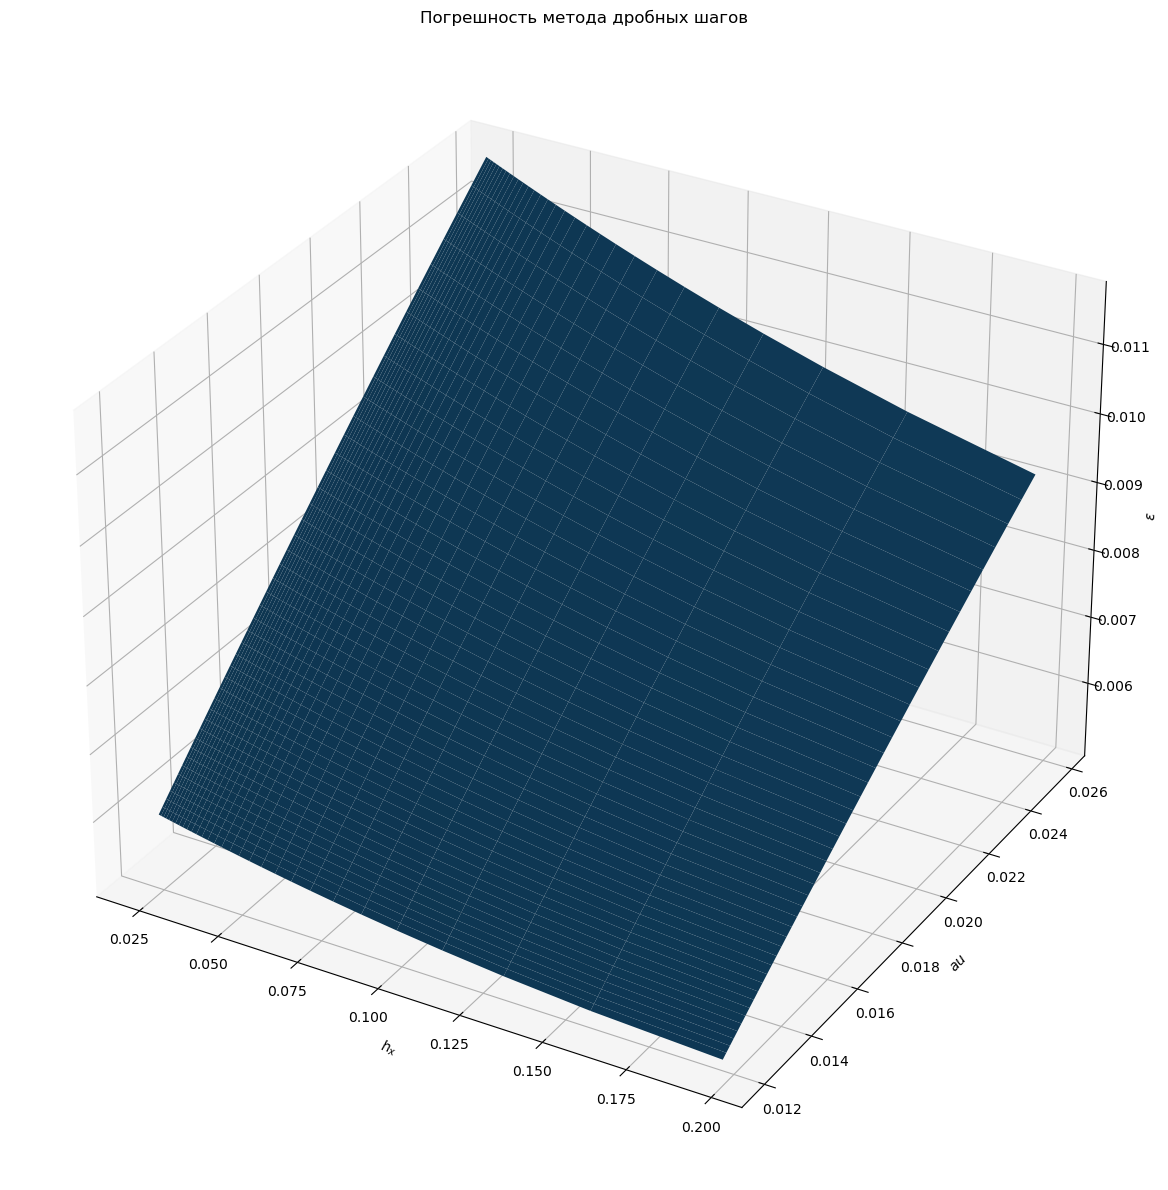

In [20]:
def plot_epsilon():
    schema = Schema(T = 1, order2nd=False)
    h = []
    tau = []
    eps = []
    for i in tqdm(range(30)):
        h.append([])
        tau.append([])
        eps.append([])
        for j in range(45):
            N = i + 5
            K = j + 40
            X, Y, T, Z = schema(N, N, K)
            h[-1].append(schema.hx)
            tau[-1].append(schema.tau)
            eps[-1].append(full_epsilon(X, Y, T, Z))
            
    fig = plt.figure(num=1, figsize=(19, 12), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_surface(np.array(h), np.array(tau), np.array(eps))
    ax.set(xlabel='$h_x$', ylabel='$\tau$', zlabel='$\epsilon$', title='Погрешность метода дробных шагов')
    fig.tight_layout()

plot_epsilon()